In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
import os

arnaudfadja_african_plums_quality_and_defect_assessment_data_path = kagglehub.dataset_download('arnaudfadja/african-plums-quality-and-defect-assessment-data')

print('Data source import complete.')
print(f"Le dataset a été téléchargé dans le dossier : {arnaudfadja_african_plums_quality_and_defect_assessment_data_path}")

# Vous pouvez maintenant lister le contenu du dossier :
if arnaudfadja_african_plums_quality_and_defect_assessment_data_path:
    for item in os.listdir(arnaudfadja_african_plums_quality_and_defect_assessment_data_path):
        print(f"- {item}")

    # Si vous savez qu'il y a un sous-dossier 'train' par exemple :
    train_folder = os.path.join(arnaudfadja_african_plums_quality_and_defect_assessment_data_path, 'train')
    if os.path.isdir(train_folder):
        print(f"\nContenu du dossier 'train' :")
        for item in os.listdir(train_folder):
            print(f"-- {item}")


100%|██████████| 290M/290M [00:14<00:00, 21.1MB/s]

Extracting files...


Data source import complete.
Le dataset a été téléchargé dans le dossier : /root/.cache/kagglehub/datasets/arnaudfadja/african-plums-quality-and-defect-assessment-data/versions/1
- african_plums_dataset


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import seaborn as sns
import random
import shutil
from pathlib import Path
from tqdm import tqdm
import torch
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import Subset, Dataset, DataLoader
from torch import nn, optim
from transformers import AutoImageProcessor, ViTForImageClassification
from torch import nn, optim
import timm

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input/'):
 #   for filename in filenames:
  #      print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
#elements = os.listdir('/kaggle/working')
#print(elements)

# 1) Chargement des données

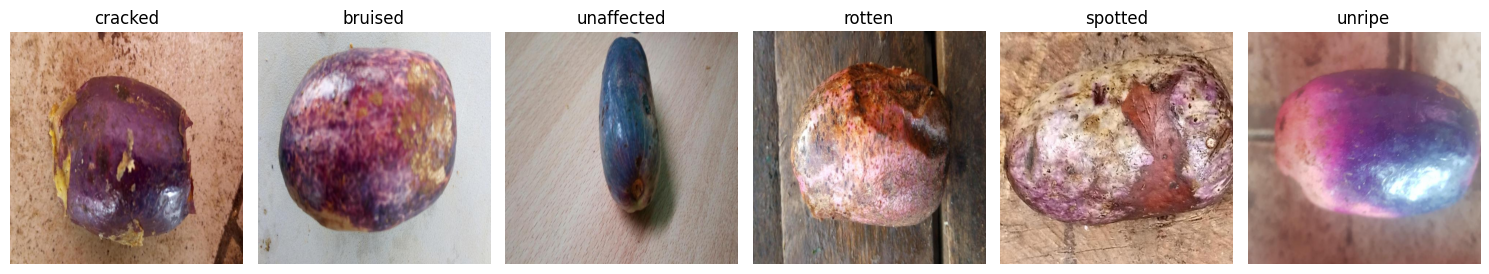

In [10]:
#repertoire racine
path = '/root/.cache/kagglehub/datasets/arnaudfadja/african-plums-quality-and-defect-assessment-data/versions/1/african_plums_dataset'

# Chemin du dossier contenant les sous-dossiers
dossier_images = os.path.join(path, 'african_plums')

# Obtenir les sous-dossiers
classes = [os.path.join(dossier_images, nom) for nom in os.listdir(dossier_images) if os.path.isdir(os.path.join(dossier_images, nom))]

# Créer une figure avec 1 ligne et 6 colonnes
fig, axes = plt.subplots(1, 6, figsize=(15, 5))

# Afficher une image de chaque dossier
for ax, dossier in zip(axes, classes[:6]):  # Limiter à 6 dossiers
    # Charger la première image du dossier
    images = os.listdir(dossier)
    if images:
        image_path = os.path.join(dossier, images[55])  # Prendre la première image
        img = Image.open(image_path)
        ax.imshow(img)
        ax.axis('off')  # Masquer les axes
        ax.set_title(os.path.basename(dossier))  # Titre avec le nom du dossier

# Afficher la figure
plt.tight_layout()
plt.show()

In [11]:
# Chemin du dossier contenant le fichier CSV
nom_fichier = 'organized_plums_data_new.csv'

# Construire le chemin complet du fichier
chemin_fichier = os.path.join(path, nom_fichier)

# Charger le fichier CSV dans un DataFrame
df = pd.read_csv(chemin_fichier)

df.sample(10)

,Image ID,Label,Defect Type
648,rotten_plum_168,defective,rotten
1351,spotted_plum_151,defective,spotted
1593,spotted_plum_393,defective,spotted
921,rotten_plum_441,defective,rotten
3939,unripe_plum_259,unripe,unripe
2871,unaffected_plum_912,good,unaffected
1305,spotted_plum_105,defective,spotted
4288,unripe_plum_608,unripe,unripe
4097,unripe_plum_417,unripe,unripe
3983,unripe_plum_303,unripe,unripe


In [12]:
df.shape

(4507, 3)

In [13]:
df.columns = ['Image_Id', 'Label', 'class']
df.sample(10)

,Image_Id,Label,class
3325,unaffected_plum_1366,good,unaffected
2123,unaffected_plum_164,good,unaffected
3338,unaffected_plum_1379,good,unaffected
1031,rotten_plum_551,defective,rotten
3436,unaffected_plum_1477,good,unaffected
2355,unaffected_plum_396,good,unaffected
3155,unaffected_plum_1196,good,unaffected
4211,unripe_plum_531,unripe,unripe
269,bruised_plum_270,defective,bruised
766,rotten_plum_286,defective,rotten


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4507 entries, 0 to 4506
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Image_Id  4507 non-null   object
 1   Label     4507 non-null   object
 2   class     4507 non-null   object
dtypes: object(3)
memory usage: 105.8+ KB


In [15]:
df.isna().sum(axis=0)

,0
Image_Id,0
Label,0
class,0


In [16]:
df.duplicated().sum()
print(f"Nombre total de valeurs dupliquées : {df.duplicated().sum()}")

Nombre total de valeurs dupliquées : 0


In [17]:
print("Nombre total d'image pour chaque type de classe :")
df.groupby('class').size()

Nombre total d'image pour chaque type de classe :


,0
class,
bruised,319
cracked,162
rotten,720
spotted,759
unaffected,1721
unripe,826


In [18]:
df.groupby('Label')['class'].agg(lambda x: list(set(x))).reset_index()

,Label,class
0,defective,"[rotten, bruised, cracked, spotted]"
1,good,[unaffected]
2,unripe,[unripe]


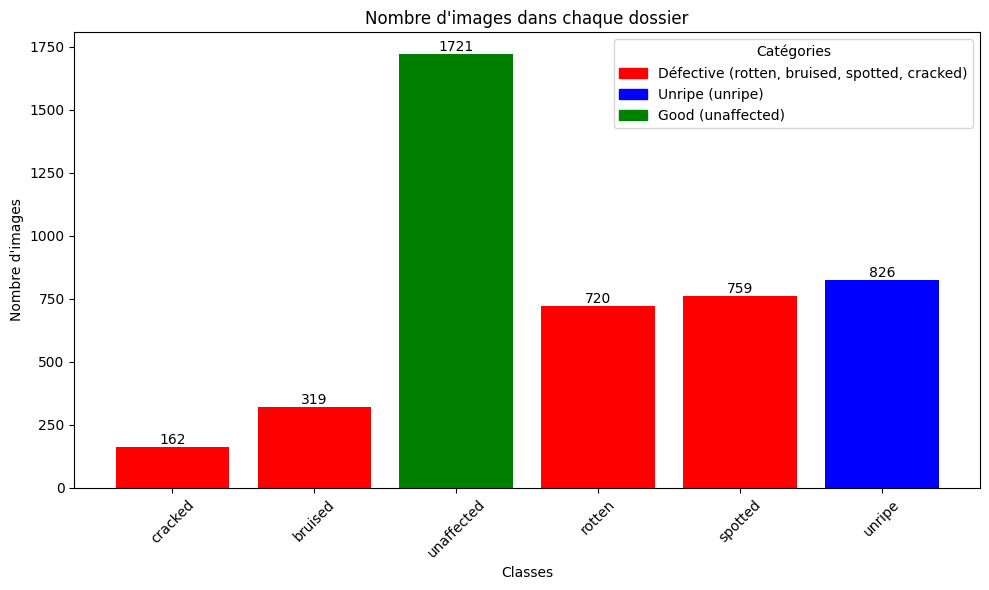

In [19]:
# Initialiser les listes pour les noms de dossiers et le nombre d'images
noms_dossiers = []
nombre_images = []

# Compter le nombre d'images dans chaque sous-dossier
for nom in os.listdir(dossier_images):
    chemin_dossier = os.path.join(dossier_images, nom)
    if os.path.isdir(chemin_dossier):
        images = [f for f in os.listdir(chemin_dossier) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]
        noms_dossiers.append(nom)
        nombre_images.append(len(images))

# Déterminer les couleurs des barres
couleurs = ['red' if nom in ['rotten', 'bruised', 'spotted', 'cracked'] else 'blue' if nom == 'unripe' else 'green' for nom in noms_dossiers]

# Créer l'histogramme
plt.figure(figsize=(10, 6))
ax = plt.bar(noms_dossiers, nombre_images, color=couleurs)

# Ajouter des étiquettes sur les barres
plt.bar_label(ax)

# Configurer les axes et le titre
plt.xlabel('Classes')
plt.ylabel('Nombre d\'images')
plt.title('Nombre d\'images dans chaque dossier')
plt.xticks(rotation=45)
plt.tight_layout()  # Ajuster l'espacement
# Ajouter la légende
plt.legend(
    handles=[
        plt.Rectangle((0, 0), 1, 1, color='red', label='Défective (rotten, bruised, spotted, cracked)'),
        plt.Rectangle((0, 0), 1, 1, color='blue', label='Unripe (unripe)'),
        plt.Rectangle((0, 0), 1, 1, color='green', label='Good (unaffected)')
    ],
    title='Catégories'
)
plt.show()

# 2) Prétraitement des images

In [20]:
def compter_elements(chemin, display_element=False):
    try:
        # Lister les éléments dans le répertoire
        elements = os.listdir(chemin)
        # Compter le nombre d'éléments
        nombre_elements = len(elements)

        if display_element:
            print(f"Éléments du répertoire : {elements}")

        print(f"Nombre d'éléments : {nombre_elements}")

    except FileNotFoundError:
        return "Le chemin spécifié n'existe pas."
    except PermissionError:
        return "Accès refusé au chemin spécifié."

In [21]:
compter_elements(path, True)

Éléments du répertoire : ['organized_plums_data_new.csv', 'african_plums', 'README.md']
Nombre d'éléments : 3


In [22]:
path

'/root/.cache/kagglehub/datasets/arnaudfadja/african-plums-quality-and-defect-assessment-data/versions/1/african_plums_dataset'

## 2.1) Configuration des chemins

In [23]:
# Définir les chemins
work_path = os.getcwd()
path_data = os.path.join(path, 'african_plums')  # Dossier source
data_use = os.path.join(work_path, '/data')            # Dossier cible
folder_model_1 = os.path.join(work_path, '/model_1')
folder_model_2 = os.path.join(work_path, '/model_2')
train_val_temp_1 = os.path.join(folder_model_1, 'train_val_temp_1')
train_val_temp_2 = os.path.join(folder_model_2, 'train_val_temp_2')
test_1 = os.path.join(folder_model_1, 'test_1')
test_2 = os.path.join(folder_model_2, 'test_2')

In [24]:
# Fonction pour créer un dossier (et le recréer s'il existe)
def create_folder(path):
    if os.path.exists(path):
        shutil.rmtree(path)
        print(f"🗑️ Dossier existant supprimé : {path}")
    os.makedirs(path)
    print(f"📁 Nouveau dossier créé : {path}")

# Création des dossiers nécessaires
print("🔧 Création des dossiers requis...")
create_folder(data_use)
create_folder(folder_model_1)
create_folder(folder_model_2)
create_folder(train_val_temp_1)
create_folder(train_val_temp_2)
create_folder(test_1)
create_folder(test_2)

# Fonction pour copier les fichiers/dossiers avec barre de progression
def copy_with_progress(src, dst):
    if not os.path.exists(dst):
        os.makedirs(dst)

    items = os.listdir(src)
    print(f"\n📦 Copie de {len(items)} éléments de '{src}' vers '{dst}'...\n")

    for item in tqdm(items, desc="📤 Copie en cours", unit="élément"):
        s = os.path.join(src, item)
        d = os.path.join(dst, item)
        if os.path.isdir(s):
            shutil.copytree(s, d)
        else:
            shutil.copy2(s, d)

# Lancer la copie
copy_with_progress(path_data, data_use)

print("\n✅ Opération terminée avec succès ! Tous les fichiers ont été copiés 🎉")

🔧 Création des dossiers requis...
📁 Nouveau dossier créé : /data
📁 Nouveau dossier créé : /model_1
📁 Nouveau dossier créé : /model_2
📁 Nouveau dossier créé : /model_1/train_val_temp_1
📁 Nouveau dossier créé : /model_2/train_val_temp_2
📁 Nouveau dossier créé : /model_1/test_1
📁 Nouveau dossier créé : /model_2/test_2

📦 Copie de 6 éléments de '/root/.cache/kagglehub/datasets/arnaudfadja/african-plums-quality-and-defect-assessment-data/versions/1/african_plums_dataset/african_plums' vers '/data'...



📤 Copie en cours: 100%|██████████| 6/6 [00:01<00:00,  4.48élément/s]


✅ Opération terminée avec succès ! Tous les fichiers ont été copiés 🎉


In [25]:
compter_elements(work_path, True)
compter_elements(data_use, True)
compter_elements(folder_model_1, True)
compter_elements(folder_model_2, True)

Éléments du répertoire : ['.config', 'sample_data']
Nombre d'éléments : 2
Éléments du répertoire : ['cracked', 'bruised', 'unaffected', 'rotten', 'spotted', 'unripe']
Nombre d'éléments : 6
Éléments du répertoire : ['train_val_temp_1', 'test_1']
Nombre d'éléments : 2
Éléments du répertoire : ['train_val_temp_2', 'test_2']
Nombre d'éléments : 2


#### Séparation des images en test et trai_val

In [26]:
# Classes à traiter
classes_model_1 = ['spotted', 'cracked', 'bruised', 'unaffected', 'unripe', 'rotten']
classes_model_2 = ['spotted', 'cracked', 'bruised', 'rotten']

def split_images(source_root, target_train, target_test, classes, ratio=0.1):
    for class_name in tqdm(classes, desc="🔍 Traitement des classes", unit="classe"):
        source_class_dir = os.path.join(source_root, class_name)
        images = os.listdir(source_class_dir)
        random.shuffle(images)

        test_count = int(len(images) * ratio)
        test_images = images[:test_count]
        train_images = images[test_count:]

        # Dossiers cibles
        class_train_dir = os.path.join(target_train, class_name)
        class_test_dir = os.path.join(target_test, class_name)

        os.makedirs(class_train_dir, exist_ok=True)
        os.makedirs(class_test_dir, exist_ok=True)

        # Copier les images de test
        for img in test_images:
            src = os.path.join(source_class_dir, img)
            dst = os.path.join(class_test_dir, img)
            shutil.copy2(src, dst)

        # Copier les images de train_val
        for img in train_images:
            src = os.path.join(source_class_dir, img)
            dst = os.path.join(class_train_dir, img)
            shutil.copy2(src, dst)

        print(f"📂 Classe '{class_name}': {len(train_images)} entraînement/val | {len(test_images)} test")

# Séparation pour le model_1
print("\n🚀 Séparation pour le model_1")
split_images(data_use, train_val_temp_1, test_1, classes_model_1)

# Séparation pour le model_2
print("\n🚀 Séparation pour le model_2")
split_images(data_use, train_val_temp_2, test_2, classes_model_2)

print("\n✅ Séparation terminée avec succès pour les deux modèles ! 🎉")


🚀 Séparation pour le model_1


🔍 Traitement des classes:  50%|█████     | 3/6 [00:00<00:00,  8.29classe/s]

📂 Classe 'spotted': 684 entraînement/val | 75 test
📂 Classe 'cracked': 146 entraînement/val | 16 test
📂 Classe 'bruised': 288 entraînement/val | 31 test


🔍 Traitement des classes:  83%|████████▎ | 5/6 [00:00<00:00,  4.75classe/s]

📂 Classe 'unaffected': 1549 entraînement/val | 172 test
📂 Classe 'unripe': 744 entraînement/val | 82 test


🔍 Traitement des classes: 100%|██████████| 6/6 [00:01<00:00,  5.27classe/s]


📂 Classe 'rotten': 648 entraînement/val | 72 test

🚀 Séparation pour le model_2


🔍 Traitement des classes:  25%|██▌       | 1/4 [00:00<00:00,  6.40classe/s]

📂 Classe 'spotted': 684 entraînement/val | 75 test
📂 Classe 'cracked': 146 entraînement/val | 16 test
📂 Classe 'bruised': 288 entraînement/val | 31 test


🔍 Traitement des classes: 100%|██████████| 4/4 [00:00<00:00, 10.79classe/s]

📂 Classe 'rotten': 648 entraînement/val | 72 test

✅ Séparation terminée avec succès pour les deux modèles ! 🎉


In [27]:
compter_elements(train_val_temp_1, True)
compter_elements(test_1, True)
compter_elements(train_val_temp_2, True)
compter_elements(test_2, True)

Éléments du répertoire : ['cracked', 'bruised', 'unaffected', 'rotten', 'spotted', 'unripe']
Nombre d'éléments : 6
Éléments du répertoire : ['cracked', 'bruised', 'unaffected', 'rotten', 'spotted', 'unripe']
Nombre d'éléments : 6
Éléments du répertoire : ['cracked', 'bruised', 'rotten', 'spotted']
Nombre d'éléments : 4
Éléments du répertoire : ['cracked', 'bruised', 'rotten', 'spotted']
Nombre d'éléments : 4


In [28]:
# Dossiers à fusionner
defective_classes = ['spotted', 'cracked', 'bruised', 'rotten']

# Chemins vers les sous-dossiers de model_1
#train_val_temp_1 = os.path.join('model_1', 'train_val_temp_1')
#test_1 = os.path.join('model_1', 'test_1')

def merge_to_defective(root_dir):
    defective_path = os.path.join(root_dir, 'defective')
    os.makedirs(defective_path, exist_ok=True)

    # Liste dynamique des classes à fusionner à partir du contenu réel
    class_names = os.listdir(root_dir)
    for class_name in class_names:
        class_path = os.path.join(root_dir, class_name)

        # On ne fusionne que les classes "défectueuses"
        if class_name in ['spotted', 'cracked', 'bruised', 'rotten'] and os.path.isdir(class_path):
            images = os.listdir(class_path)
            for img in tqdm(images, desc=f"📦 Fusion '{class_name}' → 'defective' ({root_dir})", unit="img"):
                src = os.path.join(class_path, img)
                dst = os.path.join(defective_path, img)

                # Renommage si doublon
                if os.path.exists(dst):
                    base, ext = os.path.splitext(img)
                    count = 1
                    while os.path.exists(dst):
                        dst = os.path.join(defective_path, f"{base}_{count}{ext}")
                        count += 1

                shutil.move(src, dst)

            # Supprimer le dossier une fois fusion terminé
            shutil.rmtree(class_path)
            print(f"🗑️ Supprimé : {class_path}")

        elif class_name in ['unaffected', 'unripe']:
            print(f"✅ Conservé : {class_name}")

    print(f"\n✅ Structure finale dans {root_dir} : {os.listdir(root_dir)}")

# Appliquer pour train_val_temp_1 et test_1
print("\n🚀 Fusion des classes défectueuses dans 'train_val_temp_1'")
merge_to_defective(train_val_temp_1)

print("\n🚀 Fusion des classes défectueuses dans 'test_1'")
merge_to_defective(test_1)

print("\n✅ Fusion terminée avec succès pour model_1 ! 🎉")


🚀 Fusion des classes défectueuses dans 'train_val_temp_1'


📦 Fusion 'cracked' → 'defective' (/model_1/train_val_temp_1): 100%|██████████| 146/146 [00:00<00:00, 32699.76img/s]


🗑️ Supprimé : /model_1/train_val_temp_1/cracked


📦 Fusion 'bruised' → 'defective' (/model_1/train_val_temp_1): 100%|██████████| 288/288 [00:00<00:00, 37091.52img/s]


🗑️ Supprimé : /model_1/train_val_temp_1/bruised
✅ Conservé : unaffected


📦 Fusion 'rotten' → 'defective' (/model_1/train_val_temp_1): 100%|██████████| 648/648 [00:00<00:00, 20634.15img/s]


🗑️ Supprimé : /model_1/train_val_temp_1/rotten


📦 Fusion 'spotted' → 'defective' (/model_1/train_val_temp_1): 100%|██████████| 684/684 [00:00<00:00, 21313.03img/s]


🗑️ Supprimé : /model_1/train_val_temp_1/spotted
✅ Conservé : unripe

✅ Structure finale dans /model_1/train_val_temp_1 : ['unaffected', 'defective', 'unripe']

🚀 Fusion des classes défectueuses dans 'test_1'


📦 Fusion 'cracked' → 'defective' (/model_1/test_1): 100%|██████████| 16/16 [00:00<00:00, 20478.75img/s]


🗑️ Supprimé : /model_1/test_1/cracked


📦 Fusion 'bruised' → 'defective' (/model_1/test_1): 100%|██████████| 31/31 [00:00<00:00, 20332.04img/s]


🗑️ Supprimé : /model_1/test_1/bruised
✅ Conservé : unaffected


📦 Fusion 'rotten' → 'defective' (/model_1/test_1): 100%|██████████| 72/72 [00:00<00:00, 17228.02img/s]


🗑️ Supprimé : /model_1/test_1/rotten


📦 Fusion 'spotted' → 'defective' (/model_1/test_1): 100%|██████████| 75/75 [00:00<00:00, 19192.97img/s]

🗑️ Supprimé : /model_1/test_1/spotted
✅ Conservé : unripe

✅ Structure finale dans /model_1/test_1 : ['unaffected', 'defective', 'unripe']

✅ Fusion terminée avec succès pour model_1 ! 🎉


In [29]:
compter_elements(train_val_temp_1, True)
compter_elements(test_1, True)
compter_elements(train_val_temp_2, True)
compter_elements(test_2, True)

Éléments du répertoire : ['unaffected', 'defective', 'unripe']
Nombre d'éléments : 3
Éléments du répertoire : ['unaffected', 'defective', 'unripe']
Nombre d'éléments : 3
Éléments du répertoire : ['cracked', 'bruised', 'rotten', 'spotted']
Nombre d'éléments : 4
Éléments du répertoire : ['cracked', 'bruised', 'rotten', 'spotted']
Nombre d'éléments : 4


In [30]:
compter_elements(train_val_temp_1, False)
compter_elements(train_val_temp_2, False)

Nombre d'éléments : 3
Nombre d'éléments : 4


#### Data augmentation, équilibrage des données et création des dossiers train et val des différents dossiers model_1 et model_2

In [31]:
def get_transforms():
    return transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(20),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0))
    ])

def augment_to_balance(input_dir):
    transform = get_transforms()

    # Statistiques des classes
    class_counts = {}
    class_images = {}

    for cls in os.listdir(input_dir):
        cls_path = os.path.join(input_dir, cls)
        if not os.path.isdir(cls_path):
            continue
        images = [img for img in os.listdir(cls_path) if img.lower().endswith(('.jpg', '.jpeg', '.png'))]
        if not images:
            continue
        class_counts[cls] = len(images)
        class_images[cls] = images

    if not class_counts:
        print(f"⚠️ Aucune image trouvée dans {input_dir}. Traitement ignoré.")
        return

    max_count = max(class_counts.values())
    target_count = max(max_count, 1500)  # La cible est le max actuel ou 1000, le plus grand des deux
    print(f"\n📊 Classe la plus représentée initialement dans {input_dir} : {max_count} images")
    print(f"🎯 Nombre cible d'images par classe dans {input_dir} : {target_count} images")

    for cls in tqdm(class_images, desc=f"🧪 Augmentation dans {input_dir}", unit="classe"):
        cls_path = os.path.join(input_dir, cls)
        images = class_images[cls]
        current_count = len(images)
        i = 0
        while current_count < target_count:
            img_name = random.choice(images)
            img_path = os.path.join(cls_path, img_name)
            try:
                image = Image.open(img_path).convert("RGB")
                aug_img = transform(image)
                aug_name = f"{os.path.splitext(img_name)[0]}_aug{i}.jpg"
                aug_path = os.path.join(cls_path, aug_name)
                aug_img.save(aug_path)
                current_count += 1
                i += 1
            except Exception as e:
                print(f"⚠️ Erreur sur {img_path} : {e}")
                continue

    print(f"✅ Data augmentation terminée pour {input_dir} 🎉")

# 📁 Exécution sur les deux dossiers :
augment_to_balance(train_val_temp_1)
augment_to_balance(train_val_temp_2)


📊 Classe la plus représentée initialement dans /model_1/train_val_temp_1 : 1766 images
🎯 Nombre cible d'images par classe dans /model_1/train_val_temp_1 : 1766 images


🧪 Augmentation dans /model_1/train_val_temp_1: 100%|██████████| 3/3 [00:43<00:00, 14.48s/classe]


✅ Data augmentation terminée pour /model_1/train_val_temp_1 🎉

📊 Classe la plus représentée initialement dans /model_2/train_val_temp_2 : 684 images
🎯 Nombre cible d'images par classe dans /model_2/train_val_temp_2 : 1500 images


🧪 Augmentation dans /model_2/train_val_temp_2: 100%|██████████| 4/4 [02:08<00:00, 32.14s/classe]

✅ Data augmentation terminée pour /model_2/train_val_temp_2 🎉


In [32]:
def split_train_val(input_dir, output_dir, train_ratio=0.8):
    """
    Sépare les images de chaque classe dans un dossier en 80% train / 20% val.
    :param input_dir: train_val_temp_1 ou train_val_temp_2
    :param output_dir: model_1 ou model_2
    :param train_ratio: proportion des données pour l'entraînement
    """
    # Création des dossiers "train" et "val"
    train_dir = os.path.join(output_dir, 'train')
    val_dir = os.path.join(output_dir, 'val')
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)

    # Parcours des classes présentes dans le dossier temporaire
    for class_name in os.listdir(input_dir):
        class_path = os.path.join(input_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        # Liste des images
        images = [img for img in os.listdir(class_path)
                  if img.lower().endswith(('.jpg', '.jpeg', '.png'))]
        random.shuffle(images)

        # Split des images
        split_index = int(len(images) * train_ratio)
        train_images = images[:split_index]
        val_images = images[split_index:]

        # Création des dossiers de sortie pour chaque classe
        train_class_dir = os.path.join(train_dir, class_name)
        val_class_dir = os.path.join(val_dir, class_name)
        os.makedirs(train_class_dir, exist_ok=True)
        os.makedirs(val_class_dir, exist_ok=True)

        # Déplacement des images vers le dossier train
        for img in tqdm(train_images, desc=f"📁 {class_name} → train", unit="img"):
            shutil.move(os.path.join(class_path, img), os.path.join(train_class_dir, img))

        # Déplacement des images vers le dossier val
        for img in tqdm(val_images, desc=f"📁 {class_name} → val", unit="img"):
            shutil.move(os.path.join(class_path, img), os.path.join(val_class_dir, img))

    # Nettoyage du dossier temporaire une fois le split terminé
    print(f"\n🧹 Suppression du dossier temporaire : {input_dir}")
    shutil.rmtree(input_dir)
    print(f"✅ Split terminé pour {output_dir} ! 🎉")


# ✨ Application aux deux modèles
split_train_val(train_val_temp_1, folder_model_1)
split_train_val(train_val_temp_2, folder_model_2)

📁 unripe → val: 100%|██████████| 354/354 [00:00<00:00, 35886.88img/s]



🧹 Suppression du dossier temporaire : /model_1/train_val_temp_1
✅ Split terminé pour /model_1 ! 🎉


📁 spotted → val: 100%|██████████| 300/300 [00:00<00:00, 37403.50img/s]


🧹 Suppression du dossier temporaire : /model_2/train_val_temp_2
✅ Split terminé pour /model_2 ! 🎉


In [33]:
compter_elements(train_val_temp_1, False)

"Le chemin spécifié n'existe pas."

In [34]:
compter_elements(train_val_temp_2, False)

"Le chemin spécifié n'existe pas."

In [35]:
compter_elements(folder_model_1, True)
compter_elements(folder_model_1 + '/train', True)
compter_elements(folder_model_1 + '/val', True)
compter_elements(folder_model_1 + '/test_1', True)
compter_elements(folder_model_2, True)
compter_elements(folder_model_2  + '/train', True)
compter_elements(folder_model_2 + '/val', True)
compter_elements(folder_model_2 + '/test_1', True)

Éléments du répertoire : ['val', 'train', 'test_1']
Nombre d'éléments : 3
Éléments du répertoire : ['unaffected', 'defective', 'unripe']
Nombre d'éléments : 3
Éléments du répertoire : ['unaffected', 'defective', 'unripe']
Nombre d'éléments : 3
Éléments du répertoire : ['unaffected', 'defective', 'unripe']
Nombre d'éléments : 3
Éléments du répertoire : ['val', 'train', 'test_2']
Nombre d'éléments : 3
Éléments du répertoire : ['cracked', 'bruised', 'rotten', 'spotted']
Nombre d'éléments : 4
Éléments du répertoire : ['cracked', 'bruised', 'rotten', 'spotted']
Nombre d'éléments : 4


"Le chemin spécifié n'existe pas."

# 3) Conception du model

In [36]:
class Config:
    """
    Configuration pour les modèles de classification hiérarchique.
    Définit les chemins des données, les noms des classes et les hyperparamètres d'entraînement.
    """
    # Paths pour model_1 (classification de niveau supérieur en 3 classes)
    MODEL1 = {
        'train': folder_model_1 + '/train',  # Chemin vers le répertoire d'entraînement du modèle 1.
        'val': folder_model_1 + '/val',      # Chemin vers le répertoire de validation du modèle 1.
        'test': folder_model_1 + '/test_1',  # Chemin vers le répertoire de test du modèle 1.
        'classes': ['defective', 'unaffected', 'unripe'], # Liste des noms des classes pour le modèle 1.
        'num_classes': 3                     # Nombre de classes pour le modèle 1.
    }

    # Paths pour model_2 (classification de niveau inférieur en 4 classes, pour les cas 'defective')
    MODEL2 = {
        'train': folder_model_2  + '/train', # Chemin vers le répertoire d'entraînement du modèle 2.
        'val': folder_model_2 + '/val',      # Chemin vers le répertoire de validation du modèle 2.
        'test': folder_model_2 + '/test_2',  # Chemin vers le répertoire de test du modèle 2.
        'classes': ['spotted', 'cracked', 'bruised', 'rotten'], # Liste des noms des classes pour le modèle 2.
        'num_classes': 4                     # Nombre de classes pour le modèle 2.
    }

    # Paramètres communs pour l'entraînement et le traitement des données
    BATCH_SIZE = 32    # Taille du lot utilisée pour les DataLoaders.
    NUM_EPOCHS = 15    # Nombre total d'époques d'entraînement.
    LR = 2e-5          # Taux d'apprentissage initial pour les optimiseurs.
    PATIENCE = 5       # Nombre d'époques sans amélioration de la perte de validation avant l'arrêt anticipé.
    IMG_SIZE = 224     # Taille cible (carrée) pour le redimensionnement des images.

In [37]:
class HierarchicalDataset(Dataset):
    """
    Dataset personnalisé pour charger des images organisées en une structure de répertoires hiérarchique.
    Chaque sous-répertoire du répertoire racine est considéré comme une classe.
    """
    def __init__(self, root_dir, model_name='vit_base_patch16_224', augment=False):
        """
        Initialise le dataset.

        Args:
            root_dir (str): Chemin vers le répertoire racine contenant les sous-répertoires de classes.
            model_name (str, optional): Nom du modèle timm utilisé pour obtenir les stats de normalisation.
                                         Par défaut, 'vit_base_patch16_224'.
            augment (bool, optional): Indique si des augmentations de données doivent être appliquées.
                                             Par défaut, False.
        """
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        self.model_name = model_name
        pretrained_cfg = timm.get_pretrained_cfg(self.model_name)
        self.mean = pretrained_cfg.mean
        self.std = pretrained_cfg.std
        self.image_size = pretrained_cfg.input_size[-2:] # (H, W)

        self.transform = transforms.Compose([
            transforms.Resize(self.image_size),
            transforms.Lambda(lambda img: img.convert('RGB')),
            transforms.ToTensor(),
            transforms.Normalize(mean=self.mean, std=self.std)
        ] + ([
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(0.2, 0.2, 0.2)
        ] if augment else []))

        self.samples = []
        for cls in self.classes:
            cls_dir = os.path.join(root_dir, cls)
            for img_name in os.listdir(cls_dir):
                self.samples.append((
                    os.path.join(cls_dir, img_name),
                    self.class_to_idx[cls]
                ))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path)
        return self.transform(image), label

In [38]:
class HierarchicalViT(nn.Module):
    """
    Un modèle ViT hiérarchique composé de deux modèles ViT distincts,
    implémentés en utilisant la librairie timm.
    Le premier modèle effectue une classification de niveau supérieur,
    et le second modèle est utilisé pour une classification plus fine
    sur un sous-ensemble des prédictions du premier modèle.
    """
    def __init__(self):
        """
        Initialise le modèle HierarchicalViT en utilisant des modèles ViT de timm.
        """
        super().__init__()

        # Modèle principal (niveau 1) pour la classification en 3 classes.
        # Utilise 'vit_base_patch16_224' de timm, pré-entraîné sur ImageNet.
        # Nous remplaçons la tête de classification pour avoir le nombre de classes souhaité.
        self.model1 = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=Config.MODEL1['num_classes'])

        # Modèle secondaire (niveau 2) pour la classification en 4 classes.
        # Utilise également 'vit_base_patch16_224' de timm, pré-entraîné sur ImageNet.
        # Nous remplaçons la tête de classification pour avoir le nombre de classes souhaité.
        self.model2 = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=Config.MODEL2['num_classes'])

        # Gélification (freezing) des couches d'embedding (couches basses) du modèle principal.
        # Cela signifie que les poids de ces couches ne seront pas mis à jour pendant l'entraînement de self.model1.
        # C'est une technique de transfer learning pour conserver les caractéristiques de bas niveau apprises sur un grand dataset.
        for name, param in self.model1.named_parameters():
            if 'blocks.0' in name or 'patch_embed' in name or 'norm_pre' in name or 'pos_embed' in name:
                param.requires_grad = False

        # Gélification des couches d'embedding du modèle secondaire pour les mêmes raisons.
        for name, param in self.model2.named_parameters():
            if 'blocks.0' in name or 'patch_embed' in name or 'norm_pre' in name or 'pos_embed' in name:
                param.requires_grad = False

    def forward(self, x, mode='joint'):
        """
        Définit la passe forward du modèle.

        Args:
            x (torch.Tensor): Le tenseur d'entrée représentant les images.
            mode (str, optional): Le mode de fonctionnement du modèle.
                                 'joint': Exécute les deux modèles.
                                 'model1': Exécute uniquement le premier modèle.
                                 'model2': Exécute uniquement le deuxième modèle.
                                 Par défaut, 'joint'.

        Returns:
            torch.Tensor ou tuple:
                Si mode='joint': Retourne un tuple contenant :
                    - out1 (torch.Tensor): Les logits de sortie du premier modèle.
                    - out2 (torch.Tensor ou None): Les logits de sortie du deuxième modèle pour les entrées filtrées par le masque, ou None si le masque est vide.
                    - mask (torch.Tensor): Un masque booléen indiquant les échantillons qui ont été passés au deuxième modèle.
                Si mode='model1': Retourne les logits de sortie du premier modèle.
                Si mode='model2': Retourne les logits de sortie du deuxième modèle.
        """
        if mode == 'joint':
            # Passe forward à travers le premier modèle pour obtenir les logits.
            out1 = self.model1(x)
            # Crée un masque booléen où True indique les échantillons pour lesquels la prédiction du premier modèle est la classe d'index 0 (supposément 'defective').
            mask = (torch.argmax(out1, dim=1) == 0)
            # Si au moins un échantillon correspond à la condition du masque, passe ces échantillons à travers le deuxième modèle pour obtenir ses logits.
            # Sinon (si mask.any() est False), out2 est None.
            out2 = self.model2(x[mask]) if mask.any() else None
            # Retourne les sorties des deux modèles et le masque utilisé.
            return out1, out2, mask
        elif mode == 'model1':
            # Retourne uniquement les logits du premier modèle.
            return self.model1(x)
        else: # mode == 'model2'
            # Retourne uniquement les logits du deuxième modèle.
            return self.model2(x)

In [39]:
def train_joint_model_with_validation():
    # Initialisation du dispositif (GPU si disponible, sinon CPU).
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Création des datasets d'entraînement
    train_dataset1 = HierarchicalDataset(Config.MODEL1['train'], augment=False)
    train_dataset2 = HierarchicalDataset(Config.MODEL2['train'], augment=False) # Dataset pour les défauts

    # Création des DataLoaders
    train_loader1 = DataLoader(train_dataset1, batch_size=Config.BATCH_SIZE, shuffle=True)
    train_loader2 = DataLoader(train_dataset2, batch_size=Config.BATCH_SIZE, shuffle=True) # DataLoader pour les défauts

    # Initialisation du modèle hiérarchique
    model = HierarchicalViT().to(device)
    opt1 = optim.AdamW(model.model1.parameters(), lr=Config.LR)
    opt2 = optim.AdamW(model.model2.parameters(), lr=Config.LR/2)

    best_val_loss_model1 = float('inf')
    epochs_without_improvement = 0

    for epoch in range(Config.NUM_EPOCHS):
        model.train()

        for batch in train_loader1:
            inputs = batch[0].to(device)
            labels = batch[1].to(device)
            opt1.zero_grad()
            outputs1 = model(inputs, mode='model1')
            loss1 = nn.CrossEntropyLoss()(outputs1, labels)
            loss1.backward()
            opt1.step()

        for batch in train_loader2:
            inputs = batch[0].to(device)
            labels = batch[1].to(device)
            opt2.zero_grad()
            outputs2 = model(inputs, mode='model2')
            loss2 = nn.CrossEntropyLoss()(outputs2, labels)
            loss2.backward()
            opt2.step()

        val_loss_model1, val_acc_model1 = validate_joint_model(model, device, Config.MODEL1['val'], Config.MODEL2['val'])
        print(f"Epoch {epoch+1}/{Config.NUM_EPOCHS}, Val Loss (Model 1): {val_loss_model1:.4f}, Val Acc (Model 1): {val_acc_model1:.4f}")

        val_loss_model2, val_acc_model2 = validate_model2(model, device, Config.MODEL2['val'])
        print(f"Epoch {epoch+1}/{Config.NUM_EPOCHS}, Val Loss (Model 2): {val_loss_model2:.4f}, Val Acc (Model 2): {val_acc_model2:.4f}")

        if val_loss_model1 < best_val_loss_model1:
            best_val_loss_model1 = val_loss_model1
            torch.save(model.state_dict(), 'best_model.pth')
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= Config.PATIENCE:
                print(f"Arrêt anticipé après {epoch+1} époques.")
                break

    return model

In [40]:
def validate_model2(model, device, val_dir2):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    val_dataset2 = HierarchicalDataset(val_dir2, augment=False)
    val_loader2 = DataLoader(val_dataset2, batch_size=Config.BATCH_SIZE)

    with torch.no_grad():
        for x2, y2 in val_loader2:
            x2, y2 = x2.to(device), y2.to(device)
            logits2 = model(x2, mode='model2')
            loss = nn.CrossEntropyLoss()(logits2, y2)
            total_loss += loss.item() * x2.size(0)
            predictions = torch.argmax(logits2, dim=1)
            correct_predictions += (predictions == y2).sum().item()
            total_samples += y2.size(0)

    avg_loss = total_loss / total_samples
    accuracy = correct_predictions / total_samples
    return avg_loss, accuracy

In [41]:
def validate_joint_model(model, device, val_dir1, val_dir2):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    val_dataset1 = HierarchicalDataset(val_dir1, augment=False)
    val_loader1 = DataLoader(val_dataset1, batch_size=Config.BATCH_SIZE)

    with torch.no_grad():
        for x1, y1 in val_loader1:
            x1, y1 = x1.to(device), y1.to(device)
            logits1 = model(x1, mode='model1')
            loss = nn.CrossEntropyLoss()(logits1, y1)
            total_loss += loss.item() * x1.size(0)
            predictions = torch.argmax(logits1, dim=1)
            correct_predictions += (predictions == y1).sum().item()
            total_samples += y1.size(0)

    avg_loss = total_loss / total_samples
    accuracy = correct_predictions / total_samples
    return avg_loss, accuracy

In [42]:
def predict(image_path, model, device):
    image = Image.open(image_path).convert('RGB')
    # Récupérer les infos de prétraitement pour le modèle
    mean, std = timm.data.resolve_data_config(timm.get_pretrained_cfg('vit_base_patch16_224'))['mean'], \
                   timm.data.resolve_data_config(timm.get_pretrained_cfg('vit_base_patch16_224'))['std']
    image_size = timm.data.resolve_data_config(timm.get_pretrained_cfg('vit_base_patch16_224'))['input_size'][-2:]

    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])

    x = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        logits1, logits2, mask = model(x)

    pred1 = torch.argmax(logits1, dim=1).item()
    result = {'status': Config.MODEL1['classes'][pred1]}

    if result['status'] == 'defective' and logits2 is not None:
        pred2 = torch.argmax(logits2, dim=1).item()
        result['defect_type'] = Config.MODEL2['classes'][pred2]

    return result


In [43]:
def evaluate_model(model, device, test_dir1, test_dir2):
    model.eval()
    total_correct_model1 = 0
    total_samples_model1 = 0
    total_loss_model1 = 0

    total_correct_model2 = 0
    total_samples_model2 = 0
    total_loss_model2 = 0

    test_dataset1 = HierarchicalDataset(test_dir1, augment=False)
    test_loader1 = DataLoader(test_dataset1, batch_size=Config.BATCH_SIZE)

    test_dataset2 = HierarchicalDataset(test_dir2, augment=False)
    test_loader2 = DataLoader(test_dataset2, batch_size=Config.BATCH_SIZE)

    with torch.no_grad():
        print("Évaluation de Model 1:")
        for x1, y1 in test_loader1:
            x1, y1 = x1.to(device), y1.to(device)
            logits1 = model(x1, mode='model1')
            loss1 = nn.CrossEntropyLoss()(logits1, y1)
            total_loss_model1 += loss1.item() * x1.size(0)
            predictions1 = torch.argmax(logits1, dim=1)
            total_correct_model1 += (predictions1 == y1).sum().item()
            total_samples_model1 += y1.size(0)

        avg_loss_model1 = total_loss_model1 / total_samples_model1
        accuracy_model1 = total_correct_model1 / total_samples_model1
        print(f"  Test Loss (Model 1): {avg_loss_model1:.4f}, Test Accuracy (Model 1): {accuracy_model1:.4f}")

        print("\nÉvaluation de Model 2:")
        for x2, y2 in test_loader2:
            x2, y2 = x2.to(device), y2.to(device)
            logits2 = model(x2, mode='model2')
            loss2 = nn.CrossEntropyLoss()(logits2, y2)
            total_loss_model2 += loss2.item() * x2.size(0)
            predictions2 = torch.argmax(logits2, dim=1)
            total_correct_model2 += (predictions2 == y2).sum().item()
            total_samples_model2 += y2.size(0)

        avg_loss_model2 = total_loss_model2 / total_samples_model2
        accuracy_model2 = total_correct_model2 / total_samples_model2
        print(f"  Test Loss (Model 2): {avg_loss_model2:.4f}, Test Accuracy (Model 2): {accuracy_model2:.4f}")


In [44]:
# ====================
#  EXÉCUTION PRINCIPALE
# ====================
if __name__ == "__main__":
    # Lance l'entraînement du modèle hiérarchique avec validation.
    trained_model = train_joint_model_with_validation()

    # Sauvegarde l'état (les poids) du modèle entraîné dans un fichier.
    torch.save(trained_model.state_dict(), 'ViT_model_plums_classification_timm.pth')
    print("Modèle sauvegardé sous le nom de ViT_model_plums_classification_timm.pth")

    # Évalue le modèle entraîné sur les ensembles de test pour le modèle 1 et le modèle 2.
    evaluate_model(trained_model, torch.device('cuda' if torch.cuda.is_available() else 'cpu'), Config.MODEL1['test'], Config.MODEL2['test'])

    # Exemple d'inférence
    #sample_image = 'test_image.jpg'
    #prediction = predict(sample_image, trained_model, torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
    #print(f"\nPrédiction finale : {prediction}")

    # Exemple d'inférence (commenté ou supprimé)
    # sample_image = 'test_image.jpg'
    # prediction = predict(sample_image, trained_model, processor, torch.device('cuda'))
    # print(f"\nPrédiction finale : {prediction}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Epoch 1/15, Val Loss (Model 1): 0.3682, Val Acc (Model 1): 0.8484
Epoch 1/15, Val Loss (Model 2): 0.5282, Val Acc (Model 2): 0.7900
Epoch 2/15, Val Loss (Model 1): 0.3491, Val Acc (Model 1): 0.8578
Epoch 2/15, Val Loss (Model 2): 0.4272, Val Acc (Model 2): 0.8417
Epoch 3/15, Val Loss (Model 1): 0.4138, Val Acc (Model 1): 0.8512
Epoch 3/15, Val Loss (Model 2): 0.4696, Val Acc (Model 2): 0.8425
Epoch 4/15, Val Loss (Model 1): 0.4792, Val Acc (Model 1): 0.8465
Epoch 4/15, Val Loss (Model 2): 0.4516, Val Acc (Model 2): 0.8692
Epoch 5/15, Val Loss (Model 1): 0.4688, Val Acc (Model 1): 0.8531
Epoch 5/15, Val Loss (Model 2): 0.4932, Val Acc (Model 2): 0.8600
Epoch 6/15, Val Loss (Model 1): 0.5915, Val Acc (Model 1): 0.8512
Epoch 6/15, Val Loss (Model 2): 0.4711, Val Acc (Model 2): 0.8550
Epoch 7/15, Val Loss (Model 1): 0.5702, Val Acc (Model 1): 0.8550
Epoch 7/15, Val Loss (Model 2): 0.5467, Val Acc (Model 2): 0.8608
Arrêt anticipé après 7 époques.
Modèle sauvegardé sous le nom de ViT_model_p

In [45]:
evaluate_model(trained_model, torch.device('cuda' if torch.cuda.is_available() else 'cpu'), Config.MODEL1['test'], Config.MODEL2['test'])

Évaluation de Model 1:
  Test Loss (Model 1): 0.7181, Test Accuracy (Model 1): 0.8214

Évaluation de Model 2:
  Test Loss (Model 2): 1.2619, Test Accuracy (Model 2): 0.7165
